In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

In [2]:
!pip install tensorflow

In [60]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [61]:
REAL = os.path.join('/kaggle/input/deep-voice-deepfake-voice-recognition', '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL', '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/biden-original.wav')
FAKE = os.path.join('/kaggle/input/deep-voice-deepfake-voice-recognition', '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE', '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav')

In [62]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
wave = load_wav_16k_mono(REAL)
nwave = load_wav_16k_mono(FAKE)

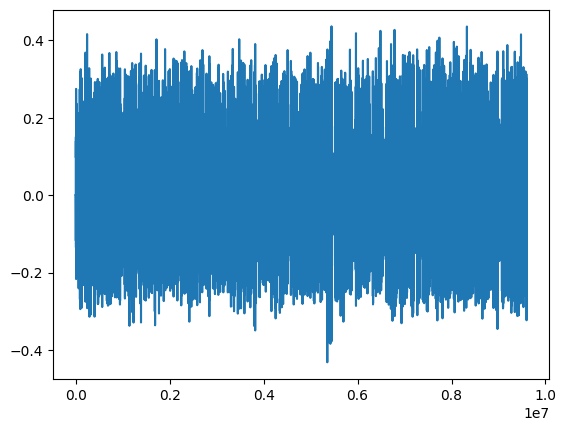

In [8]:
plt.plot(wave)

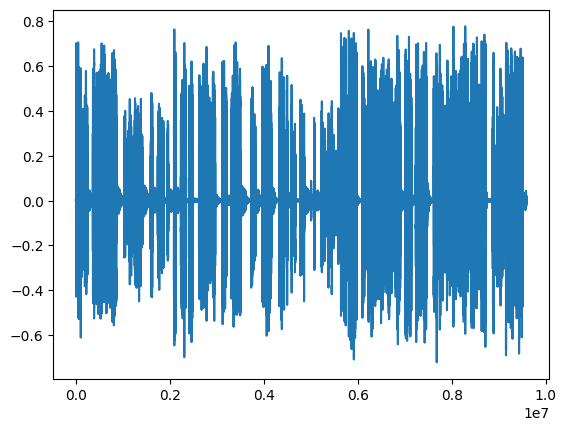

In [9]:
plt.plot(nwave)

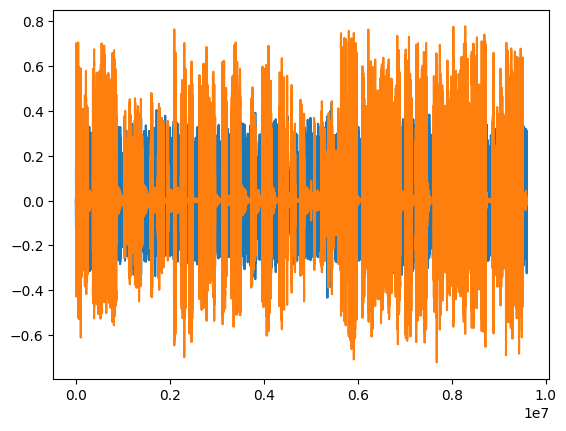

In [10]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

Create Tensorflow Dataset

In [63]:
Real = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL'
Fake = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE'

real_dataset = tf.data.Dataset.list_files(Real + '/*.wav')
fake_dataset = tf.data.Dataset.list_files(Fake + '/*.wav')

In [64]:
real_dataset.as_numpy_iterator().next()

b'/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/biden-original.wav'

In [65]:
len(real_dataset)

8

In [66]:
len(fake_dataset)

56

In [67]:
tf.ones(len(real_dataset))

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
tf.zeros(len(fake_dataset))

<tf.Tensor: shape=(56,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)>

In [69]:
realss = tf.data.Dataset.zip((real_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(real_dataset)))))
fakes = tf.data.Dataset.zip((fake_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(fake_dataset)))))
data = realss.concatenate(fakes)

In [70]:
realss.as_numpy_iterator().next()

(b'/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/margot-original.wav',
 1.0)

In [71]:
fakes.as_numpy_iterator().next()

(b'/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-margot.wav',
 0.0)

In [78]:
#real ve fake aynı formatta olsun diye
data.shuffle(10000).as_numpy_iterator().next()

(b'/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/taylor-original.wav',
 1.0)

In [79]:
len(data)

64

Calculate Wave Cycle Length

In [23]:
lengths = []
for file in os.listdir(os.path.join('/kaggle/input/deep-voice-deepfake-voice-recognition', 'KAGGLE/AUDIO/REAL')):
    tensor_wave = load_wav_16k_mono(os.path.join('/kaggle/input/deep-voice-deepfake-voice-recognition', 'KAGGLE/AUDIO/REAL', file))
    lengths.append(len(tensor_wave))

In [24]:
lengths

[9600047, 9606895, 9602820, 9607189, 1271795, 9125720, 9602140, 1499045]

In [25]:
lengths2 = []
for file in os.listdir(os.path.join('/kaggle/input/deep-voice-deepfake-voice-recognition', 'KAGGLE/AUDIO/FAKE')):
    tensor_wave2 = load_wav_16k_mono(os.path.join('/kaggle/input/deep-voice-deepfake-voice-recognition', 'KAGGLE/AUDIO/FAKE', file))
    lengths2.append(len(tensor_wave2))

In [26]:
lengths2

[9600000,
 1271795,
 9125720,
 9600000,
 9600000,
 1499045,
 9600000,
 9600000,
 1499045,
 9600000,
 9600000,
 9600000,
 1499045,
 9600000,
 9600000,
 9600000,
 9600000,
 1499045,
 1499045,
 9600000,
 1271795,
 1499045,
 1271795,
 9600000,
 1271795,
 9600000,
 9600000,
 9125720,
 9600000,
 9600000,
 9125720,
 9600000,
 9600000,
 9600000,
 9600000,
 9125720,
 9600000,
 9125720,
 9600000,
 1271795,
 9600000,
 9600000,
 9125720,
 9600000,
 9600000,
 1271795,
 9600000,
 9600000,
 9600000,
 1499045,
 9600000,
 9600000,
 9600000,
 9125720,
 9600000,
 1271795]

Calculate mean, min, max value

In [27]:
real_dataset_mean = tf.math.reduce_mean(lengths)
real_dataset_min = tf.math.reduce_min(lengths)
real_dataset_max = tf.math.reduce_max(lengths)

In [28]:
print(real_dataset_mean)
print(real_dataset_min)
print(real_dataset_max)

tf.Tensor(7489456, shape=(), dtype=int32)
tf.Tensor(1271795, shape=(), dtype=int32)
tf.Tensor(9607189, shape=(), dtype=int32)


In [30]:
real_mean_value = real_dataset_mean.numpy()
real_min_value = real_dataset_min.numpy()
real_max_value = real_dataset_max.numpy()


print('ortalama',real_mean_value/16000, 'saniye')
print('en az',real_min_value/16000, 'saniye')
print('en fazla',real_max_value/16000, 'saniye')

ortalama 468.091 saniye
en az 79.4871875 saniye
e fazla 600.4493125 saniye


In [31]:
fake_dataset_mean = tf.math.reduce_mean(lengths2)
fake_dataset_min = tf.math.reduce_min(lengths2)
fake_dataset_max = tf.math.reduce_max(lengths2)

In [32]:
fake_mean_value = fake_dataset_mean.numpy()
fake_min_value = fake_dataset_min.numpy()
fake_max_value = fake_dataset_max.numpy()


print('ortalama',fake_mean_value/16000, 'saniye')
print('en az',fake_min_value/16000, 'saniye')
print('en fazla',fake_max_value/16000, 'saniye')

ortalama 467.941875 saniye
en az 79.4871875 saniye
en fazla 600.0 saniye


preprocess

In [80]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Spectogram examples for real voice

In [81]:
filepath, label = realss.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

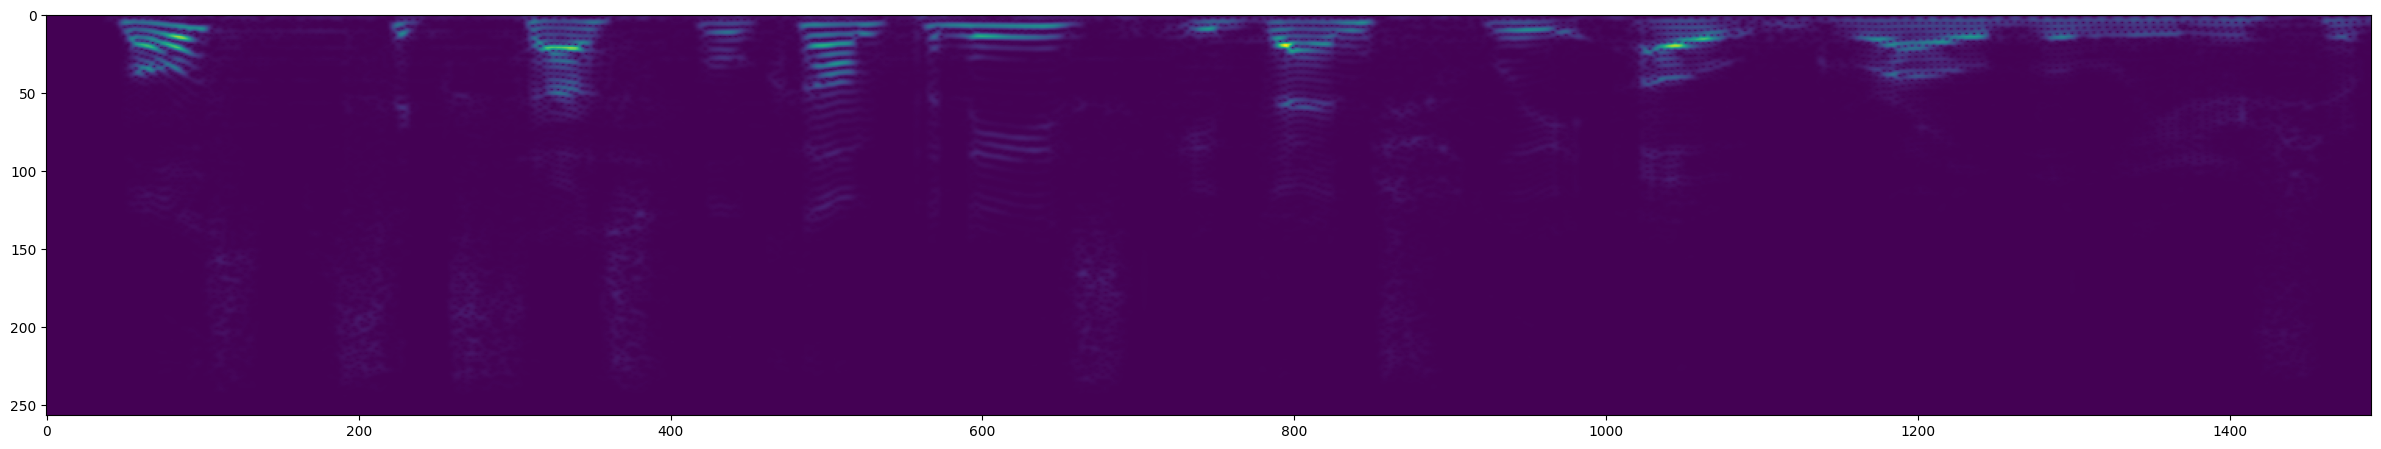

In [82]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Spectogram examples for fake voice

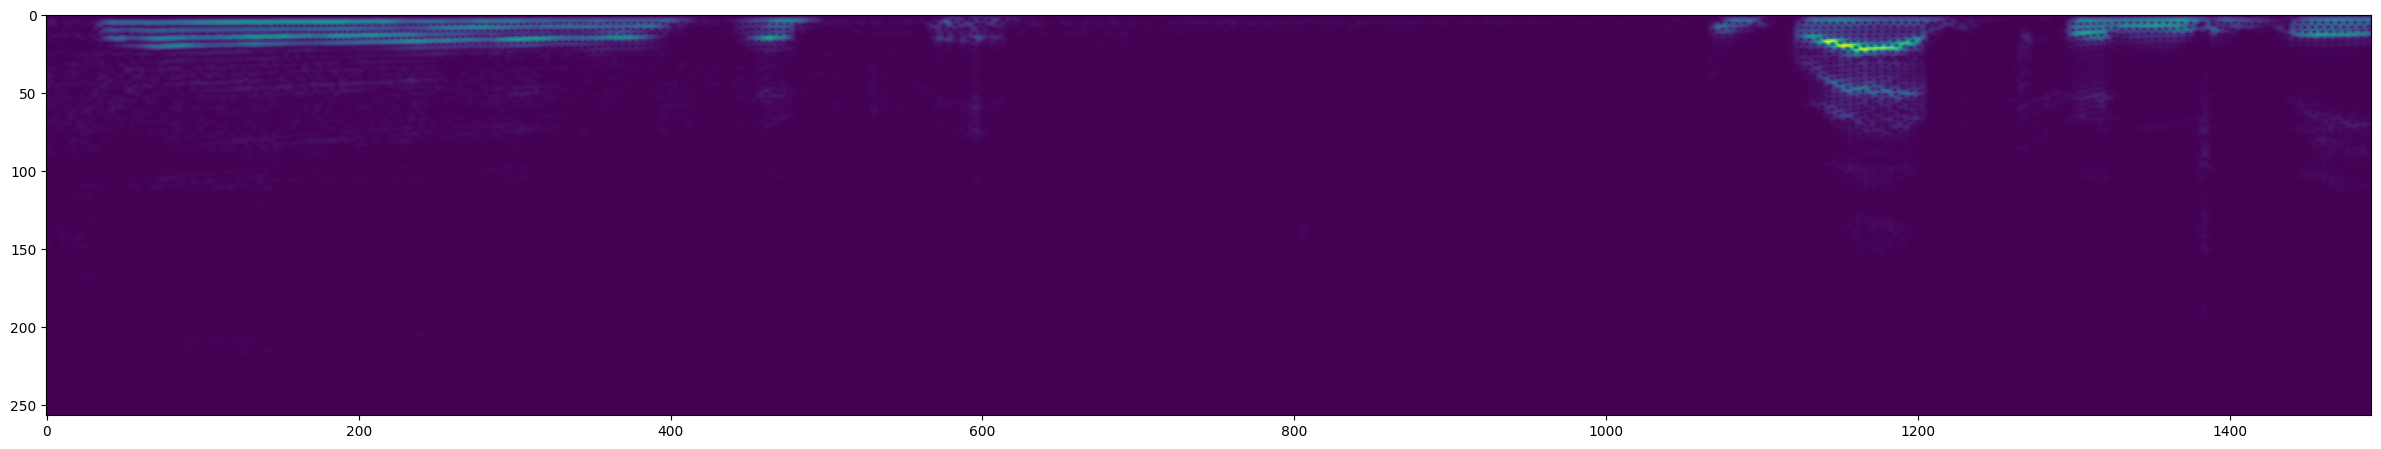

In [83]:
filepath, label = fakes.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Create a Tensorflow Data Pipeline

In [86]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [85]:
len(data)*0.7

44.8

In [87]:
train = data.take(45)
test = data.skip(45).take(19)

In [88]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

Build Model 